## Simulate a DMP-SBM

First import the library `dmprdpg`.

In [144]:
import dmprdpg
import matplotlib.pyplot as plt

Assume $K=3$ layers and $T=3$ time points, and $G=G^\prime=4$, representing the number of communities. Define a dictionary of $G\times G^\prime$ between-community probability matrices (essentially representing a $G\times G\times K\times T$ tensor). 

In [145]:
# Pre-define matrix B - Index is (layer, time)
import numpy as np
B_dict = {
    (0, 0): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (0, 1): np.array([[0.16, 0.16, 0.04, 0.10], [0.16, 0.16, 0.04, 0.10], [0.04, 0.04, 0.09, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (0, 2): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 0): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 1): np.array([[0.16, 0.16, 0.04, 0.10], [0.16, 0.16, 0.04, 0.10], [0.04, 0.04, 0.09, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (1, 2): np.array([[0.08, 0.02, 0.18, 0.10], [0.02, 0.20, 0.04, 0.10], [0.18, 0.04, 0.02, 0.02], [0.10, 0.10, 0.02, 0.06]]),
    (2, 0): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]]),
    (2, 1): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]]),
    (2, 2): np.array([[0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08], [0.08, 0.08, 0.08, 0.08]])
}
BB = dmprdpg.double_unfolding(B_dict, rows=3, cols=3, n=4, output='dense')

In [146]:
## Truncated SVD of order 4 of BB
from scipy.sparse.linalg import svds
U, S, V = svds(BB, k=4)
mu = U[:,::-1] @ np.diag(S[::-1] ** .5)
lam = V[::-1].T @ np.diag(S[::-1] ** .5)

Using the functions in `dmprdpg`, sample a DMP-SBM via the function `simulate_dpsbm`, using `B_dict`.

In [147]:
A_dict, z, z_prime = dmprdpg.simulate_dmpsbm(n=1000, B_dict=B_dict, seed=107)


In [148]:
import numpy as np
from scipy.sparse import bmat, coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

## Define a function to perform the double unfolding into a block matrix
def scarf_unfolding(matrix_dict, rows, cols, n, output='sparse'):
    if len(matrix_dict) != rows * cols:
        raise ValueError("Number of matrices in the dictionary must match rows*cols")
    # Create a list of lists for rows and columns
    matrix_list = [None for _ in range(cols*rows)]
    # Check if all row and column indices are in the correct range
    if not all(row_idx in range(rows) and col_idx in range(cols) for row_idx, col_idx in matrix_dict.keys()):
        raise ValueError("Row and column indices must be in the range [0, rows) and [0, cols) respectively")
    # Check if all indices are covered
    if not all((row_idx, col_idx) in matrix_dict for row_idx in range(rows) for col_idx in range(cols)):
        raise ValueError("Matrix dictionary must contain all indices in the range [0, rows) x [0, cols)")
    # Fill the grid with matrices from the dictionary
    for (row_idx, col_idx), matrix in matrix_dict.items():
        if matrix.shape != (n, n):
            raise ValueError("All matrices must have the same dimension.")
        if output == 'sparse' and not isinstance(matrix, csr_matrix):
            matrix = coo_matrix(matrix)  # Convert to sparse format if not already
        matrix_list[row_idx*cols + col_idx] = matrix
    A_tilde = np.bmat([a.A for a in matrix_list])  # .A converts to a dense numpy array
    # Return output
    return A_tilde

## Function to perform the truncated SVD of a sparse matrix
def sparse_svd(A_tilde, d):
    # Check if the matrix is in an appropriate sparse format or convert it
    if not isinstance(A_tilde, csr_matrix):
        A_tilde = csr_matrix(A_tilde)  # Convert to CSR format if not already
    # Compute the truncated SVD
    U, S, Vt = svds(A_tilde, k=d)
    # Sort the singular values (and corresponding singular vectors) in descending order and return output
    return U[:,::-1], S[::-1], Vt[::-1].T

## Obtain embeddings from the singular value decomposition
def get_embeddings(U, S, V):
    return U @ np.diag(np.sqrt(S)), V @ np.diag(np.sqrt(S))

## Unstack embeddings
def extract_and_concatenate(matrix, n, K, T):
    if matrix.shape[0] != n*K*T:
        raise ValueError("The number of rows in the matrix must be n * K * T")
    # Initialize an empty list to store the matrices
    matrices = []
    # Extract each block of n rows
    for i in range(K*T):
        start_col = i * n
        end_col = start_col + n
        block = matrix[start_col:end_col,:]
        matrices.append(block)
    # Concatenate the list of matrices into a tensor along the third dimension
    tensor = np.stack(matrices, axis=2)
    # Return the resulting tensor
    return tensor

## Doubly unfolded adjacency spectral embedding (DUASE)
def scarf(A_dict, K, T, d):
    # Get the size of the matrices
    n = A_dict[(0,0)].shape[0]
    # Perform the double unfolding
    A_tilde = scarf_unfolding(A_dict, K, T, n)
    # Perform the truncated SVD
    U, S, V = sparse_svd(A_tilde, d)
    # Obtain the embeddings
    X, Y = get_embeddings(U, S, V)
    # Reshape X and Y using the extract_and_concatenate function
    X = extract_and_concatenate(X, n, 1, 1)
    Y = extract_and_concatenate(Y, n, K, T)
    # Return the DUASE left and right embeddings
    return X, Y

Calculate the DUASE from the sampled adjacency matrices, using the function `duase` in `dmprdpg`. 

In [149]:
X, Y = scarf(A_dict, K=3, T=3, d=4)

Plot the output of Scarf.

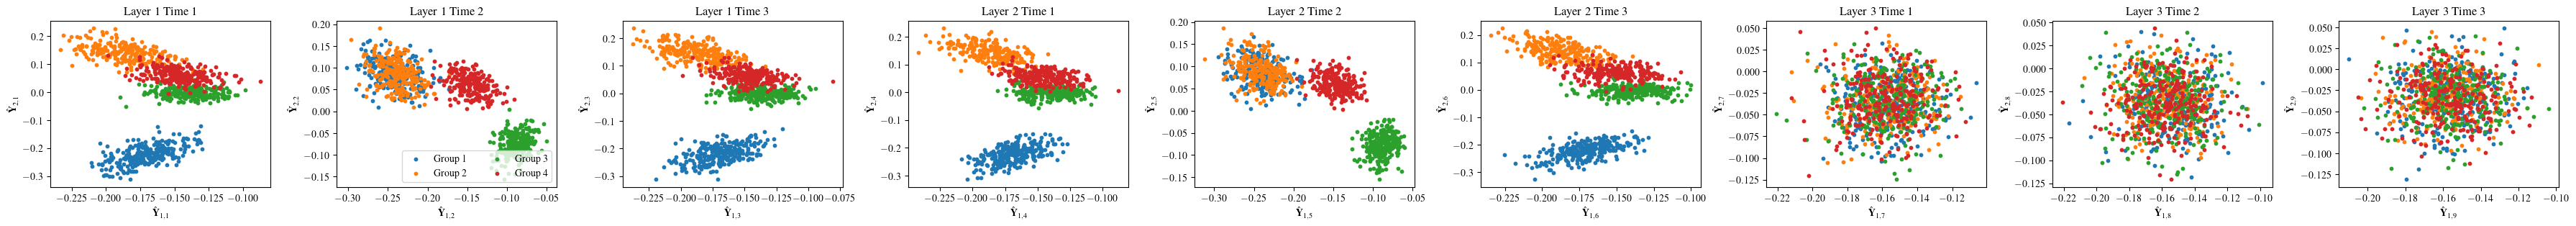

In [150]:
## Repeat for different times
fig, axs = plt.subplots(1,9, figsize=(45, 3))
plt.subplots_adjust(wspace=0.3)
for t in range(9):
    for i in range(4):
        axs[t].scatter(Y[z_prime == i, 0, t], Y[z_prime == i, 1, t], s=10)
    axs[t].set_title(f"Layer {t//3 + 1} Time {t%3 + 1}")
    axs[t].set_xlabel(r"$\hat{\mathbf{Y}}_{1," + str(t+1) + "}$")
    axs[t].set_ylabel(r"$\hat{\mathbf{Y}}_{2," + str(t+1) + "}$")
    ## Add legend only in second subfigure
    if t == 1:
        axs[t].legend([f"Group {i+1}" for i in range(4)] + ["Average", "Truth"], loc='lower right', ncol=2)
plt.show()

Apply classic multidimensional scaling on the distance matrix obtained from the right embedding $\hat{\mathbf{Y}}_t,\ t=1,\dots,T$, followed by ISOMAP.

Text(0.5, 1.0, 'Scarf Embedding + Iso-Surface')

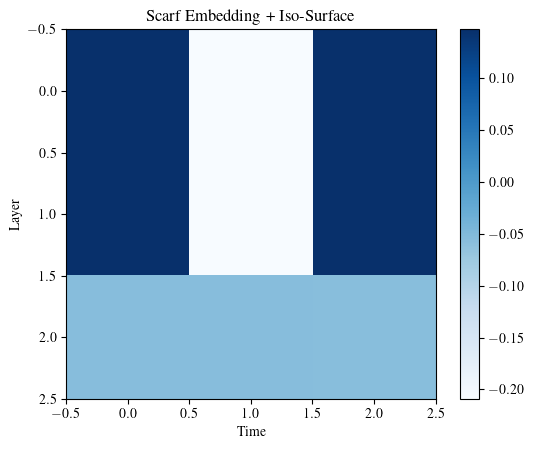

In [151]:
D = dmprdpg.distance_matrix_tensor(Y)
C = dmprdpg.cmds(D, 2)
U = dmprdpg.isomap(C, 4, 1)
iso_surf = np.reshape(U, (3,3))


plt.rc('font', family='times')
plt.imshow(iso_surf, cmap='Blues')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Layer')
plt.title('Scarf Embedding + Iso-Surface')

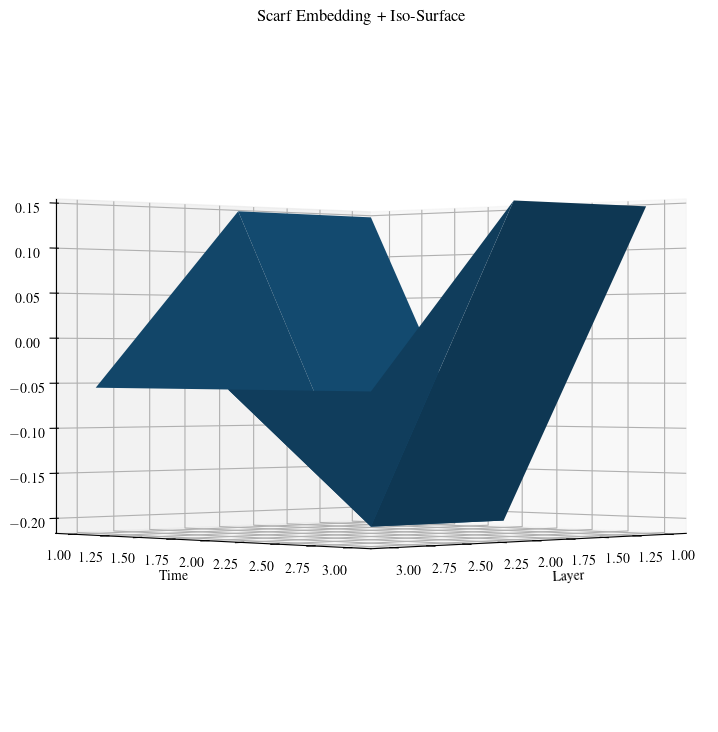

In [152]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Creating dataset
x = np.outer(np.arange(1,4), np.ones(3))

y = x.copy().T # transpose 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
surf = ax.plot_surface(x,y,iso_surf,
                       
                       edgecolor ='none')
 
ax.set_title('Scarf Embedding + Iso-Surface')
ax.set_xlabel('Layer')
ax.set_ylabel('Time')
ax.view_init(elev=0, azim=45)
 
# show plot
plt.show()